### Import packages

In [1]:
import os
import ee
import geemap
import matplotlib.pyplot as plt
# %matplotlib widget
from geemap import cartoee
from zipfile import ZipFile
from urllib.request import urlretrieve
# from urllib.parse import urljoin
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon
from pprint import pprint

In [2]:
ee.Initialize()

### Save paths and urls to variables

In [6]:
inputdir = "./data"
ne_countries_zip = "ne_10m_admin_0_countries.zip"
ne_provinces_zip = "ne_10m_admin_1_states_provinces_lines.zip"
# ne_land_zip = "ne_10m_land.zip"
ne_10m_cultural_download_url = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/"
ne_10m_physical_download_url = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/physical/"
ne_countries_shp = "ne_10m_admin_0_countries.shp"
ne_provinces_shp = "ne_10m_admin_1_states_provinces_lines.shp"
# ne_land_shp = "ne_10m_land.shp"

# define urls and paths
countries_zip_path = os.path.join(inputdir, ne_countries_zip)
provinces_zip_path = os.path.join(inputdir, ne_provinces_zip)

# explore why urljoin removes one /
ne_countries_zip_url = ne_10m_cultural_download_url + ne_countries_zip
ne_provinces_zip_url = ne_10m_cultural_download_url + ne_provinces_zip

countries_shp_path = os.path.join(inputdir, ne_countries_shp)
provinces_shp_path = os.path.join(inputdir, ne_provinces_shp)

### Download country borders for zonal statistics - source Natural Earth 

In [7]:
def get_zip(target_dir, path, url):
    """
    Check if file in `path` exists, otherwise download it from `url`
    """
    try:
        with ZipFile(path, 'r') as zip:
            # extracting all files
            print('Extracting all files...')
            zip.extractall(target_dir)
            print('Extracted!')
    except FileNotFoundError:
        print('Zip file not found, downloading now...')
        urlretrieve(url, path)
        print('Downloaded!')
        with ZipFile(path, 'r') as zip:
            # extracting all files
            print('Extracting all files...')
            zip.extractall(target_dir)
            print('Extracted!')
            # print content of target folder
        print(os.listdir(target_dir))

In [8]:
get_zip(inputdir, countries_zip_path, ne_countries_zip_url)
get_zip(inputdir, provinces_zip_path, ne_provinces_zip_url)

Extracting all files...
Extracted!
Extracting all files...
Extracted!


### Subset world countries to include only Europe (excl. Russia)

In [9]:
countries = gpd.read_file(countries_shp_path)
prov = gpd.read_file(provinces_shp_path)
countries.columns = [x.lower() for x in countries.columns]
prov.columns = [x.lower() for x in prov.columns]

# subset eu countries 
eu = countries.loc[(countries.continent == "Europe") & (countries.name != "Russia")]
# NOTE: Bug in countries df - French Guyana is France, Svalbard Islands are Norway, etc

# Define custom poly for EU
eu_poly = Polygon([
    (-18.225, 46.429),
    (-8.325, 65,554),
    (28.575, 74.329),
    (34.650, 70.279),
    (41.625, 45.754),
    (26.550, 32.254),
    (-10.800, 34.279),
    (-18.225, 46.429)
])

# # Isolate France mainland and Corsica to new df
# fr = eu.loc[eu.name == "France"]
# fr_mp = fr["geometry"].values[0]
# fr_temp_gdf = gpd.GeoDataFrame(fr_mp)
# fr_temp_gdf.columns = ['geometry']
# fr_temp_gdf = fr_temp_gdf[fr_temp_gdf.intersects(eu_poly) == True]

# # Isolate Norway to new df
# nw = eu.loc[eu.name == "Norway"]
# nw_mp = nw["geometry"].values[0]
# nw_temp_gdf = gpd.GeoDataFrame(nw_mp)
# nw_temp_gdf.columns = ['geometry']
# nw_temp_gdf = nw_temp_gdf[nw_temp_gdf.intersects(eu_poly) == True]

# # Isolate Netherlands to new df
# nh = eu.loc[eu.name == "Netherlands"]
# nh_mp = nw["geometry"].values[0]
# nh_temp_gdf = gpd.GeoDataFrame(nh_mp)
# nh_temp_gdf.columns = ['geometry']
# nh_temp_gdf = nh_temp_gdf[nh_temp_gdf.intersects(eu_poly) == True]

# # Replace records
# eu_temp = eu[~eu.name.isin(["France", "Norway", "Netherlands"])]
# eu = eu_temp.append([fr_temp_gdf, nw_temp_gdf, nw_temp_gdf])

# ### This above could have been achieved with gpd.explode()

# Explode geometries and mask the EU
eu_explo = eu.explode()
eu = eu_explo[eu_explo.intersects(eu_poly)]

<AxesSubplot:>

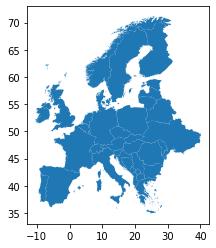

In [15]:

eu.plot()

### Clip provinces with EU countries

<AxesSubplot:>

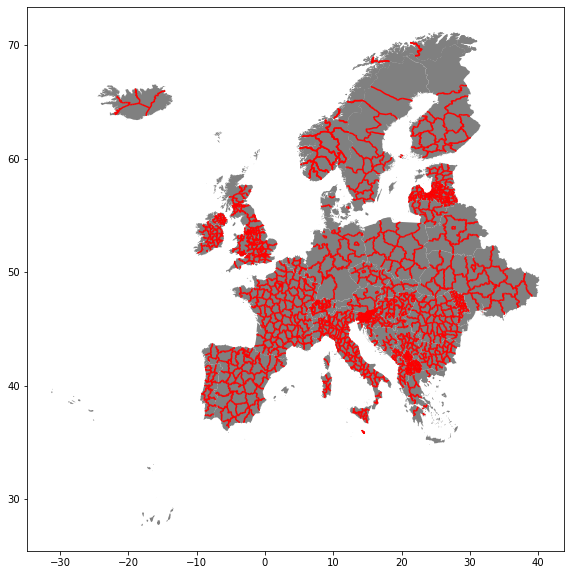

In [36]:
eu_prov = gpd.overlay(prov, eu)

ax = eu.plot(figsize=(25, 10), color='gray')
eu_prov.plot(ax=ax, color='red')

In [30]:
eu_prov.geom_type

0            LineString
1            LineString
2            LineString
3            LineString
4       MultiLineString
             ...       
4147    MultiLineString
4148         LineString
4149         LineString
4150         LineString
4151         LineString
Length: 4152, dtype: object

### Initialize leaflet Map centered on EU

In [10]:
# initialize map
Map = geemap.Map(center=[48, 8], zoom=4)
# add basemap
Map.add_basemap("CartoDB.DarkMatter")
# add country borders
Map.addLayer(eu_fc, {}, "EU Country borders")

NameError: name 'eu_fc' is not defined

### Import relavant satellite data collections

In [ ]:
start_date = '2015-04-01'
end_date = '2021-04-22'

# subsurface soil moisture # 10km res - 2 or 3 days rev
susm = ee.ImageCollection("NASA_USDA/HSL/SMAP10KM_soil_moisture")\
    .select("susm")\
    .filterDate(start_date, end_date)

susm_vps = {
    "min": 0.0,
    "max": 274.6,
    "palette": ['ff0303', 'efff07', 'efff07', '418504', '0300ff']
}

# import a land cover # all bands at 500 m res
lcc = ee.ImageCollection('MODIS/006/MCD12Q1')\
    .select("LC_Type1")\
    .filterDate(start_date, end_date)

lcc_vps = {
    "min": 1.0,
    "max": 17.0,
    "palette": [
        '05450a', '086a10', '54a708', '78d203', '009900', 'c6b044', 'dcd159',
        'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44', 'a5a5a5', 'ff6d4c',
        '69fff8', 'f9ffa4', '1c0dff'
    ]
}

# import a land surface temperature # 1km res - 1 day rev
lst = ee.ImageCollection('MODIS/006/MOD11A1')\
    .select('LST_Day_1km')\
    .filterDate(start_date, end_date)

lst_vps = {
    "min": 13000.0,
    "max": 16500.0,
    "palette": [
        '040274', '040281', '0502a3', '0502b8', '0502ce', '0502e6',
        '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
        '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
        'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
        'ff0000', 'de0101', 'c21301', 'a71001', '911003'
    ]
}


# import a ground elevation - 30m res
srtm = ee.Image('USGS/SRTMGL1_003')

### Add first image of SMAP collection, land cover, etc

In [ ]:
susm1 = ee.Image(susm.first())
lst1 = ee.Image(lst.first())
lcc1 = ee.Image(lcc.first())
Map.addLayer(susm1, susm_vps, 'First image SMAP')
Map.addLayer(lst1, lst_vps, 'First image LST')
Map.addLayer(lcc1, lcc_vps, 'First image LCC')
Map

### Define region of interest for time series analysis

In [ ]:
eu_bbox = [-10, 34, 30, 60]

# Check grid size for spatial re-sampling
ax = cartoee.get_map(susm1, region=eu_bbox, vis_params=susm_vps)
# add gridlines to the map at a specified interval
cartoee.add_gridlines(ax, interval=[2, 2], linestyle=":")
# add colorbar
cartoee.add_colorbar(ax, susm_vps, loc='right')
# set title
ax.set_title(label='Sub-Surface Soil Moisture over EU', fontsize=15)
plt.show()

### Extract data for time series analysis